In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

ModuleNotFoundError: No module named 'yfinance'

In [4]:
!pip install yfinance


     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     --- ------------------------------------ 0.3/3.0 MB ? eta -:--:--
     ------------------------------- -------- 2.4/3.0 MB 7.9 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 7.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 7.9 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.18.1-py3-none-any.whl size=139099 sha256=5602411e7d5714e71813ee34b998c408c788456aa3f000e7ebaaad74856aef69
  Stored in directory: c:\users\acer\appdata\local\pip\cache\wheels\1a\57\6

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [10]:
def load_data(ticker='BTC-USD', period='3y', interval='1d'):
    df = yf.download(ticker, period=period, interval=interval)
    df.dropna(inplace=True)
    return df

In [12]:
def add_indicators(df):
    df['SMA'] = df['Close'].rolling(window=10).mean()
    df['EMA'] = df['Close'].ewm(span=10, adjust=False).mean()
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df.dropna()

In [14]:
def create_sequences(df, sequence_length):
    features = ['Close', 'SMA', 'EMA', 'RSI']
    data = df[features].values
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(1 if data[i][0] > data[i-1][0] else 0)  # Direction
    return np.array(X), np.array(y), scaler

In [16]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
if __name__ == '__main__':
    df = load_data()
    df = add_indicators(df)
    X, y, scaler = create_sequences(df, sequence_length=60)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = build_model((X_train.shape[1], X_train.shape[2]))
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
C:\Users\ACER\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.5081 - loss: 0.6963 - val_accuracy: 0.4829 - val_loss: 0.6941
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.5069 - loss: 0.6928 - val_accuracy: 0.4878 - val_loss: 0.6935
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5155 - loss: 0.6927 - val_accuracy: 0.5122 - val_loss: 0.6936
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.5170 - loss: 0.6932 - val_accuracy: 0.5171 - val_loss: 0.6936
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.5166 - loss: 0.6937 - val_accuracy: 0.5122 - val_loss: 0.6948
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.4659 - loss: 0.6961 - val_accuracy: 0.5122 - val_loss: 0.6931
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.4929 - loss: 0.6932 - val_accuracy: 0.5317 - val_loss: 0.6933
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.5289 - loss: 0.6921 - val_accuracy: 0.5122 -

In [24]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5269 - loss: 0.6926
Test Accuracy: 0.51


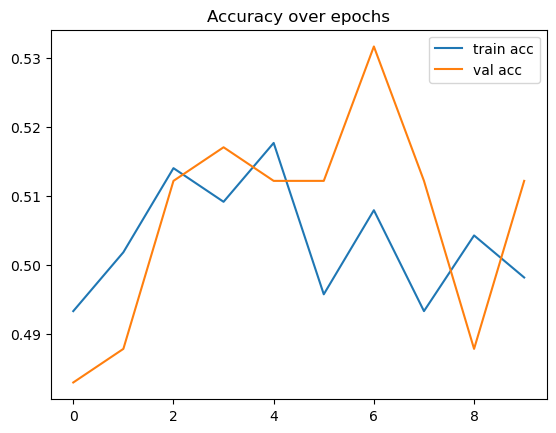

In [29]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()